# BE - Machine Learning

<span style='color:skyblue'>

## 0. Chargement des librairies 

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split

<span style='color:skyblue'>

## 1. Exploration des données 

<span style='color:skyblue'>

### 1.1 Extraction des données

</span>

Le dataset est un dataset UCML, on pourrait utiliser le module *ucmlrepo* et la methode *fetch_ucirepo* associée, mais le chargement des données est long (~2 minutes). On privilégiera donc un téléchargement et des méthodes de lecture manuelles, les données ne faisant que 600Ko

Le dataset a été construit pour prédire la target *income* qui comporte deux valeurs (>50K, <=50K) à partir de 14 features. Cette construction en "classes" nous impose de travailler avec des classifiers plutôt qu'avec des regressions.

In [217]:
names = pd.read_table("data/adult.names", sep=":", skiprows=96, header=None)[0].tolist()
names.append("income") # La target n'est pas dans le fichier des noms
adult = pd.read_csv("data/adult.data", sep=", ", names=names, engine='python', index_col=False) # Le engine permet juste d'éviter un warning

<span style='color:skyblue'>


### 1.2 Présentation des features
</span>

In [192]:
print("Nom des colonnes")
print(adult.columns.tolist())

print("\nNombre d'individus")
print(adult.shape[0])

Nom des colonnes
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

Nombre d'individus
32561


Le dataset contient différents types de features :

__Variables numériques continues :__

- __*age*__
- __*fnlwgt*__ : poids statistique attribué à chaque individu dans l'échantillon du recensement américain. Il permet d'estimer le nombre de personnes dans la population réelle représentée par cet individu du datset. Par exemple si *fnlwgt = 12000*, alors l'individu représente environ 12000 personnes dans la population totale du recensement (cf description officielle dans */data/adult.names*)

- __*capital-gain*__ : revenus supplémentaires
- __*capital-loss*__ : pertes de revenus
- __*hours-per-week*__ : nombre d'heures travaillées par semaine

__Variables numériques ordinales :__

- __*education-num*__ : nombre d'années d'éducation. --> version numérique ordinale de la feature *education*

__Variables catégorielles :__
- __*workclass*__ : type d'emploi
- __*martial-status*__ : statut marital
- __*occupation*__ : profession
- __*relationship*__ : rôle familial
- __*race*__ : race
- __*sex*__ : genre
- __*native-country*__ : pays d'origine
- __*education*__ : niveau d'éducation. --> valeurs textuelles associées à la feature *education-num*

__Variable binaire cible__ :
- __*income*__ : variable binaire pour indiquer si l'individu touche un salaire supérieur ou inférieur/égal à 50K 



<span style='color:skyblue'>

#### 1.2.1 Variables numériques

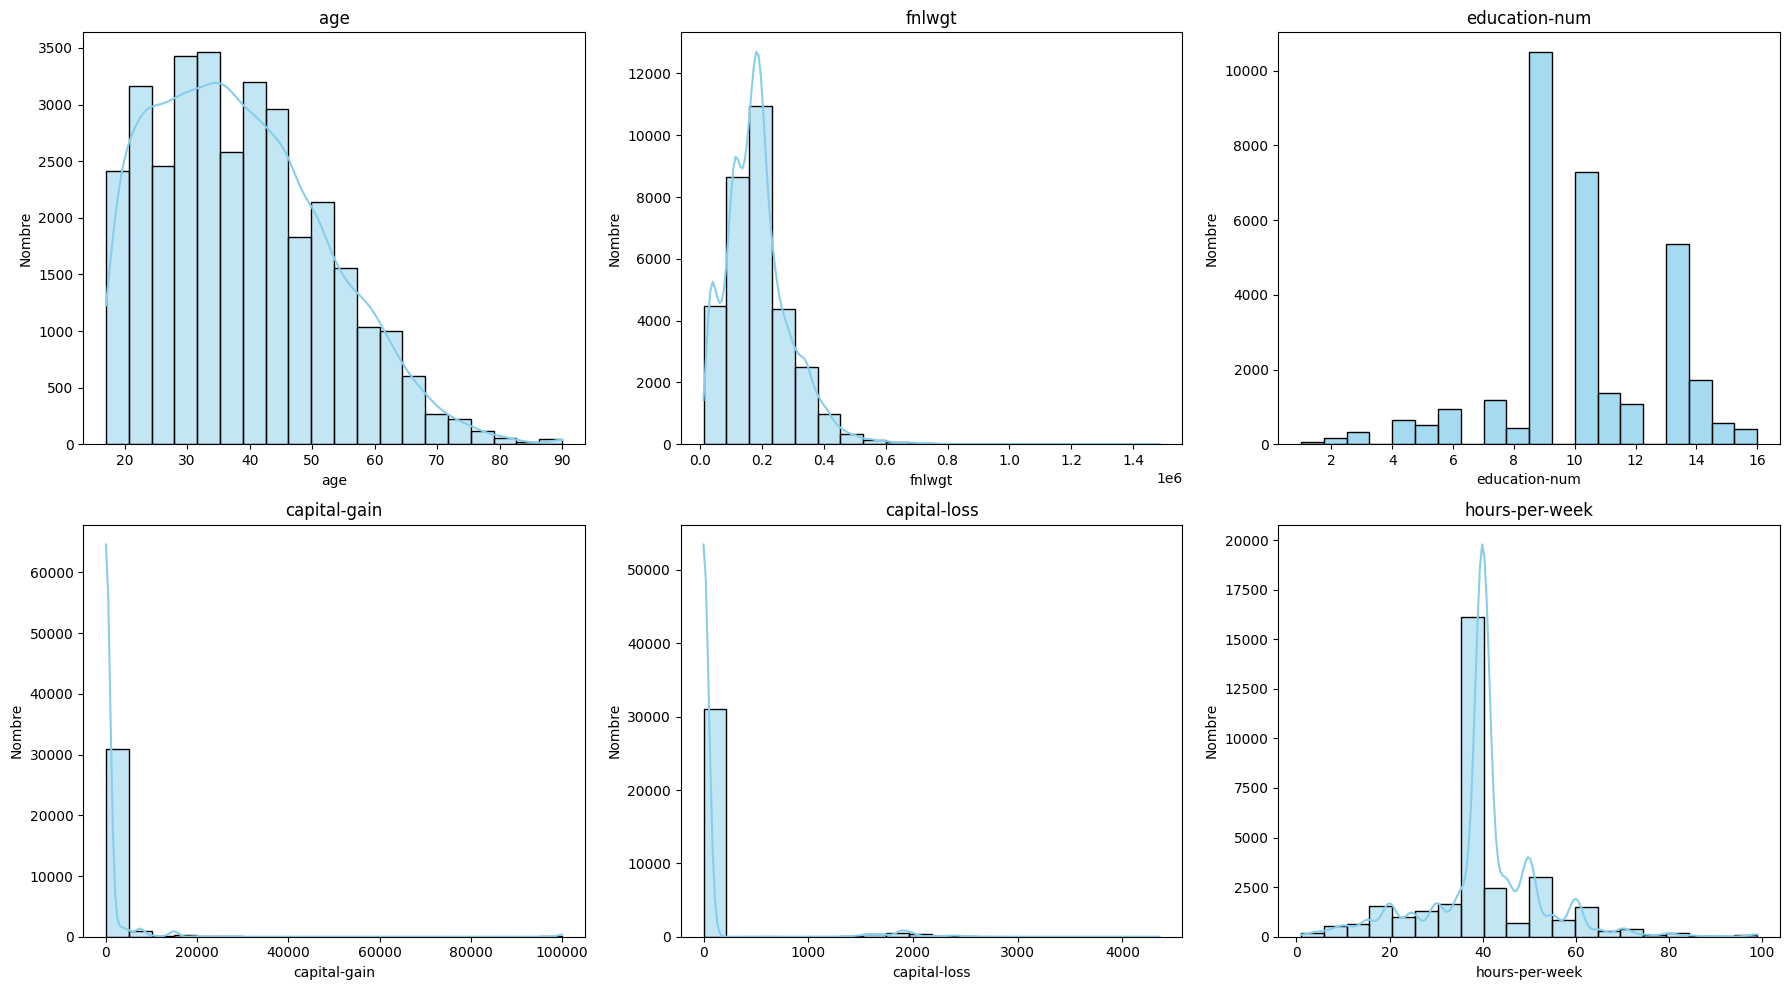

In [193]:
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  

for i, col in enumerate(numerical_features):
    if col=='education-num':
        #kde=False: pas d'estimation de la densité de proba. car la feature education-num n'est pas continue 
        sns.histplot(data=adult, x=col, bins=20, kde=False, ax=axes[i], color='skyblue') 
    else:
        #kde=True : estimation de la densité de probabilité continue 
        sns.histplot(data=adult, x=col, bins=20, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)       
    axes[i].set_ylabel("Nombre")   
plt.tight_layout()
plt.show()



Nous ne representons pas la densité de probabilité sur la feature __*education-num*__ car bien que cette variable soit numérique, elle n'est pas continue : les valeurs représentent ici des catégories de niveau d'études ordonnées.

<span style='color:skyblue'>

#### 1.2.2 Variables catégorielles 

Pour chacune des variables catégorielles du dataset, nous affichons la répartition des catégories à l’aide de barplots. Cela permet d’identifier des valeurs manquantes, des catégories peu fréquentes, ou d’éventuelles incohérences typographiques.

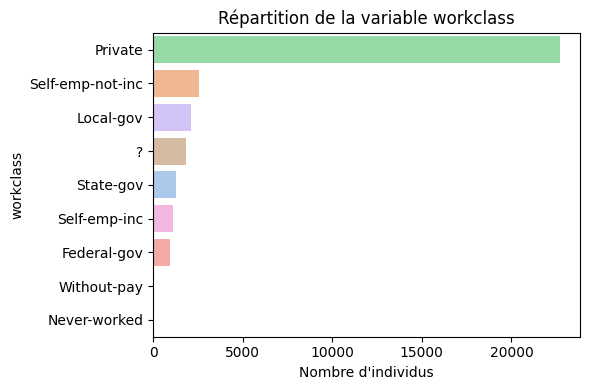

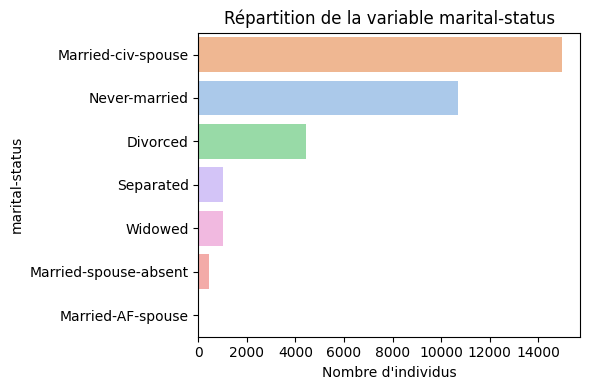

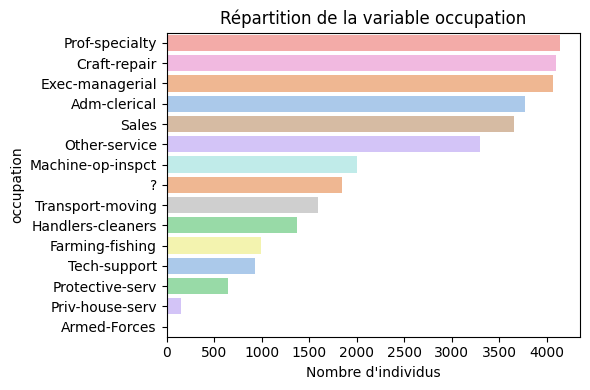

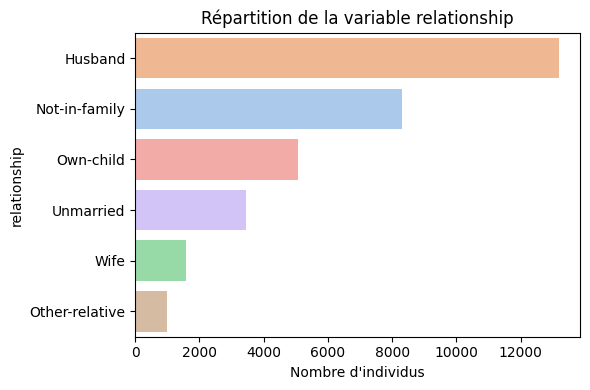

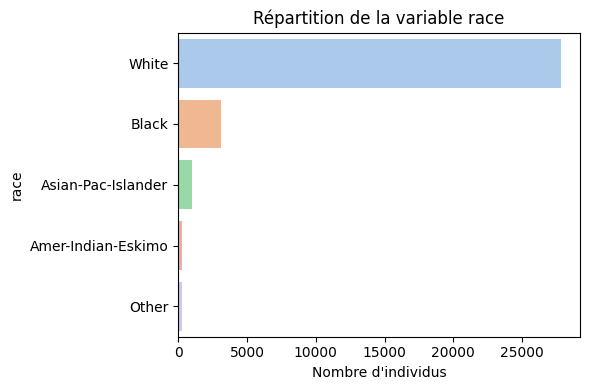

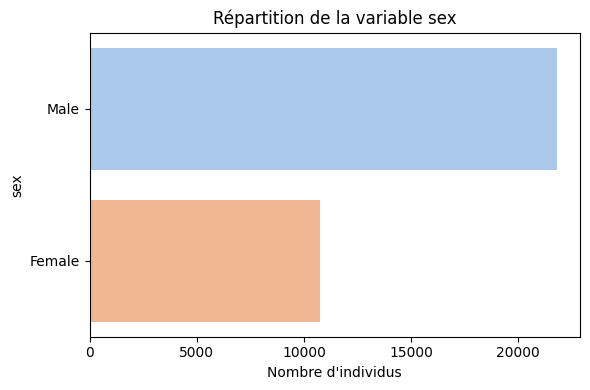

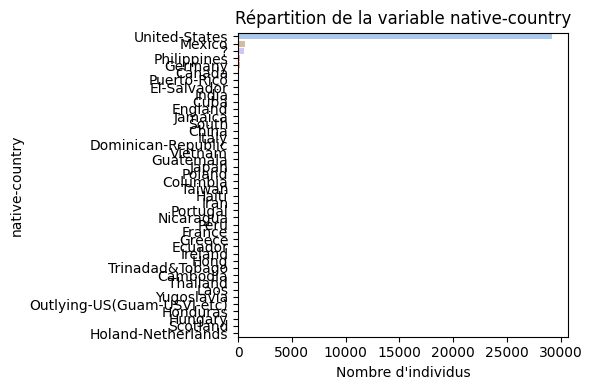

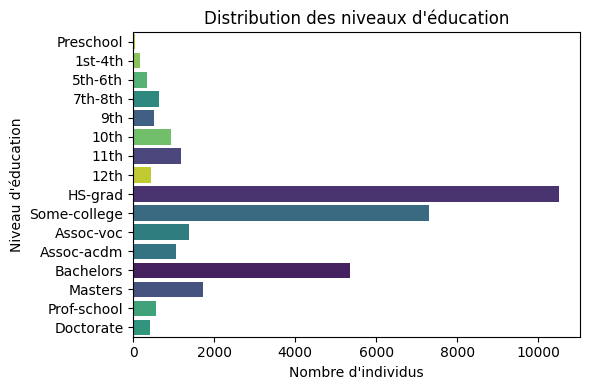


Correspondance entre education et education-num :
        education  education-num
224     Preschool              1
160       1st-4th              2
56        5th-6th              3
15        7th-8th              4
6             9th              5
77           10th              6
3            11th              7
415          12th              8
2         HS-grad              9
10   Some-college             10
14      Assoc-voc             11
13     Assoc-acdm             12
0       Bachelors             13
5         Masters             14
52    Prof-school             15
20      Doctorate             16


In [194]:
# Liste des variables catégorielles
categorical_features = ['workclass', 'marital-status', 'occupation', 
                        'relationship', 'race', 'sex', 'native-country', 'education']

#Tableau de comptage pour chaque variable
# for col in categorical_features:
#     print(f"\nVariable: {col}")
#     print(adult[col].value_counts())

# Barplots
for col in categorical_features:
    plt.figure(figsize=(6,4))
    
    if col == 'education':
        # Trier par education-num pour un ordre logique
        edu_order = adult[['education', 'education-num']].drop_duplicates().sort_values('education-num')['education'] 
        sns.countplot(y=col, data=adult, order=edu_order, palette='viridis', hue=col, legend=False)
        plt.title("Distribution des niveaux d'éducation")
        plt.xlabel("Nombre d'individus")
        plt.ylabel("Niveau d'éducation")
    else:
        # Trier par fréquence décroissante pour les autres variables
        order = adult[col].value_counts().index
        sns.countplot(y=col, data=adult, order=order, palette='pastel', hue=col, legend=False)
        plt.title(f"Répartition de la variable {col}")
        plt.xlabel("Nombre d'individus")
        plt.ylabel(col)
    
    plt.tight_layout()
    plt.show()

#Table pour education + education-num
education_mapping = adult[['education', 'education-num']].drop_duplicates().sort_values('education-num')
print("\nCorrespondance entre education et education-num :")
print(education_mapping)


Nous pouvons remarquer que pour la feature 'workclass', il existe deux catégories particulières : 'Never-worked' et 'Without-pay'. Regardons de plus près ces catégories pour voir si il serait pertinent de simplifier le dataset.

In [195]:
### Catégorie "Never-worked"

# Sélection des individus avec workclass = 'Never-worked'
never_worked_occupations = adult.loc[adult['workclass'] == 'Never-worked', 'occupation']

# Afficher les valeurs uniques
print("Professions exercées par les individus dont le type d'emploi est 'Never-worked' : ")
print(never_worked_occupations.unique())

num_never_worked = (adult['workclass'] == 'Never-worked').sum()
print("\nNombre d'individus dont le type d'emploi est 'Never-worked' :", num_never_worked)



Professions exercées par les individus dont le type d'emploi est 'Never-worked' : 
['?']

Nombre d'individus dont le type d'emploi est 'Never-worked' : 7


Les individus dont le type d'emploi est 'Never-worked' représentent une part marginale de l'échantillon, et n'ont pas de catégorie de profession associée. Nous pouvons supprimer ces individus pour les parties suivantes de l'étude car ils n'apportent pas d'information utile pour la prédiction de income.

In [196]:
### Catégorie "Without-pay"
# Sélection des individus avec workclass = 'Never-worked'
without_pay_occupations = adult.loc[adult['workclass'] == 'Without-pay', 'occupation']

# Afficher les valeurs uniques
print("\nProfessions exercées par les individus dont le type d'emploi est 'Without-pay' : ")
print(without_pay_occupations.unique())

num_without_pay= (adult['workclass'] == 'Without-pay').sum()
print("\nNombre d'individus dont le type d'emploi est 'Without-pay' :", num_without_pay)




Professions exercées par les individus dont le type d'emploi est 'Without-pay' : 
['Farming-fishing' 'Craft-repair' 'Handlers-cleaners' 'Machine-op-inspct'
 'Transport-moving' 'Adm-clerical' 'Other-service']

Nombre d'individus dont le type d'emploi est 'Without-pay' : 14


Les individus dont le type d'emploi est 'Without-pay' représentent aussi une part marginale de l'échantillon. Les catégories professionnelles associées sont variées mais peu représentées. Nous pouvons supprimer ces individus pour les parties suivantes de l'étude car ils sont extrêmment rares et peu informatifs.

<span style='color:skyblue'>

#### 1.2.3 Variable cible : __*income*__

Le dataset est déséquilibré au niveau de la variable cible : 76% des individus gagnent un salaire inférieur ou égal à 50K.

income
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64


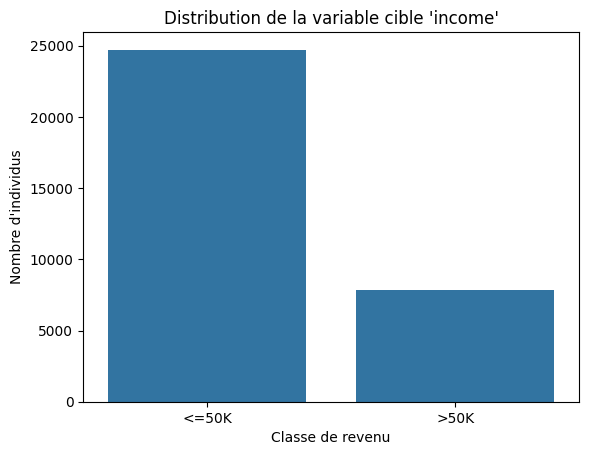

In [197]:
# Proportion de chaque classe
proportions = adult['income'].value_counts(normalize=True) * 100
print(proportions)

sns.countplot(x='income', data=adult)
plt.title("Distribution de la variable cible 'income'")
plt.xlabel("Classe de revenu")
plt.ylabel("Nombre d'individus")
plt.show()

<span style='color:skyblue'>

#### 1.2.4 Valeurs manquantes 

Nous avons remarqué en explorant les données catégorielles que pour certaines variables les catégories n'étaient pas renseignées (cf présence de '?'). Nous allons donc regarder les données manquantes par feature.


Nombre de lignes avec au moins un '?' : 2399
Proportion de lignes avec au moins un '?' : 7.367709836921471 %


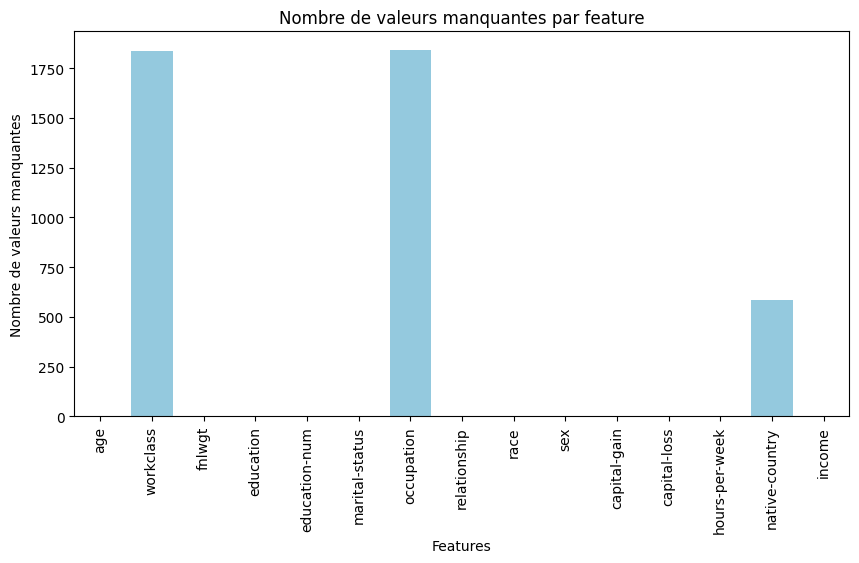

In [198]:
# Compter les lignes avec au moins un '?'
adult.replace("?", np.nan, inplace=True)  # Remplacer '?' par NaN pour faciliter le comptage
num_missing_rows = adult.isna().any(axis=1).sum()

print("Nombre de lignes avec au moins un '?' :", num_missing_rows)
print("Proportion de lignes avec au moins un '?' :", num_missing_rows/adult.shape[0] * 100, '%')


# Compter le nombre de '?' par colonne
missing_counts = adult.isna().sum()

plt.figure(figsize=(10,5))
sns.barplot(x=missing_counts.index, y=missing_counts.values, color='skyblue')
plt.xticks(rotation=90)
plt.title("Nombre de valeurs manquantes par feature")
plt.xlabel("Features")
plt.ylabel("Nombre de valeurs manquantes")
plt.show()


Seules trois variables catégorielles présentent des données manquantes. Ces données concernant 7% des individus du dataset. 

Pour chaque variable workclass, occupation, native-country, nous allons regarder la part que representent les données non renseignées parmi les autres catégories.

In [199]:
cols_with_missing = ['workclass', 'occupation', 'native-country']

for col in cols_with_missing:
    counts = adult[col].value_counts()
    total = counts.sum()

    na = adult[col].isna().sum()

    print(f"Proportion de valeurs manquantes dans la colonne '{col}': {na/total * 100:.2f}%")

Proportion de valeurs manquantes dans la colonne 'workclass': 5.98%
Proportion de valeurs manquantes dans la colonne 'occupation': 6.00%
Proportion de valeurs manquantes dans la colonne 'native-country': 1.82%


Pour chaque feature, la part des données non renseignées est non négigeable. La part des valeurs manquantes est de :
- __5.6%__ dans __*workclass*__ , 4ème catégorie parmi les 9 ;
- __5.7%__ dans __*occupation*__ , 8ème catégorie parmi les 15 ;
- __1.8%__ dans __*native-country*__ , 3ème catégorie parmi les 42 ;

On va maintenant chercher à trouver des patterns dans les valeurs manquantes. Par exemple le nombre de valeurs manquantes de workclass et de occupation semblent assez proches...

In [200]:
pd.crosstab(adult["workclass"].isna(), adult["occupation"].isna(), normalize="index")

occupation,False,True
workclass,,
False,0.999772,0.000228
True,0.000000,1.000000


<span style='color:skyblue'>

### 1.3 Conclusion sur l'exploration des données

</span>


- Rôle de la feature __*fnlwgt*__ :  

Pour rappel, chaque individu du dataset représente un certain nombre de personnes réelles dans la population US et *fnlwgt* indique ce poids.
Si l'objectif est d'utiliser des méthodes de statistique descriptive pour réaliser des analyses représentatives de la population US, il faudrait prendre cette feature en compte pour pondérer les individus. 
Or, l'objectif ici est de prédire la variable *income* à partir des autres features. Donc ne pas se servir de *fnlwgt* n'empêche pas le modèle d'apprendre les relations entre les features et la cible à partir de l'échantillon. Il faudrait donc toutefois la supprimer du dataset car elle n'a pas de sens "physique" pour la caractérisation d'un individu.

Nous allons donc ne pas prendre en compte cette feature pour le reste de l'étude.

- Déséquilibre sur la variable cible __*income*__ : __... à compléter ...__

Le dataset représente beaucoup plus d'individus gagnant <=50K, ce qui pourrait influencer les modèles qui auront tendance à prédire la classe majoritaire.
techniques de rééchantillonnage ?


- Gestion des valeurs manquantes dans  : 

Deux options possibles :

1ère : suppression des lignes avec au moins une donnée manquante : cela entraîne la suppression de 7% de nos données.
        
2ème : remplacer les '?' par une catégorie 'Unknown' --> permet de garder la donnée et de faire apprendre le modèle sur cette catégorie si celle-ci a de l'influence 
        pb : le nombre de '?' est relativement élevé dans les catégories : le modèle pourrait apprend un effet artificiel qui n'existe pas réellement dans la population.

- Suppression des individus dont le type d'emploi est 'Never-worked' et 'Without-pay' pour simplifier le dataset. (voir *1.2.2 Variables catégorielles*)

<span style='color:skyblue'>

## 2. Préparation et transformation des données - feature engineering phase

### Nettoyage et Pre processing (Feature Eng ?)

Avant de mettre en place des modèles il nous fait nettoyer un peu les données pour pouvoir les exploiter. En particulier, nous aimerions supprimer les *valuers manquantes* ainsi que les *outliers*. En mettant en place les algo classiques, nous nous sommes vite rendu compte d'un problème : la plupart des catégories sont encodées sous forme de texte. Ainsi les algo ne peuvent fonctionner. C'est la raison pour laquelle nous allons mettre en place cette pipeline de nettoyage :
- **Suppression des #NA :** Les NA étant encodés par des "?" (il n'y a pas de NA sinon) nous allons supprimer chaque lignes qui en comportent
- **Encodage des colonnes :** Nous allons encoder chaque colonnes de la façon suivante : chaque valeur unique se voit attribuer un entier. Nous n'avons que peu de recul pour l'instant et ne savons pas si c'est pertinent
- **Normalisation :** POur contrer l'effet du nombre e colonnes, nous allons normaliser celles ci

Nous avons également décidé d'enlever la colonne race pour ne pas introduire et reproduire ces biais non shouaitables dans nos algorithmes


In [218]:
#### Suppression des NA ####
adult.replace("?", pd.NA, inplace=True)  # Les NA sont codés par des "?"

adult.drop(columns=["race"], inplace=True)  # On enlève la colonne race

for key in adult.keys():
    n_na = adult[key].isna().sum()
    if n_na > 0:
        print(f"{key} : {n_na} NA")

adult.dropna(inplace=True)  # On supprime les lignes avec NA

workclass : 1836 NA
occupation : 1843 NA
native-country : 583 NA


In [219]:
#### Encodage des colonnes ####
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in adult.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    adult[column] = le.fit_transform(adult[column])
    label_encoders[column] = le

In [220]:
#### Normalisation ####
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for column in adult.columns:
    if column != "income" and column != "fnlwgt":  # On ne normalise pas la target
        adult[[column]] = scaler.fit_transform(adult[[column]])

### Tests sur les outliers ? - jsp si il faut garder

In [ ]:
from sklearn.ensemble import IsolationForest

def remove_outliers(adult):
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outliers = iso_forest.fit_predict(adult.drop(columns=["income"]))
    mask = outliers != -1
    return adult[mask]

print(f"Nombre de lignes après suppression des NA : {adult.shape[0]}")
adult_sans_outliers = remove_outliers(adult)
print(f"Nombre de lignes après suppression des outliers : {adult_sans_outliers.shape[0]}")

Nombre de lignes après suppression des NA : 30162
Nombre de lignes après suppression des outliers : 30162
Nombre de lignes après suppression des outliers : 27145


<span style='color:skyblue'>

## 3. Apprentissage des modèles - learning phase

Pour la phase d'apprentissage nous allons entraîner un classifieur, la target *income* étant encodée sur 2 valeurs. Pour *tester ce que ça donne* On va regarder si introduire les poids dans l'entraînement change quelque chose aux performance du modèle.

On choisit deux modèles pour l'instant, RandomForest et XGB, puis nous concluerons sur les performances de chacun pour passer en phase 4 et 5

In [236]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold  

def random_forest_cv(adult, WEIGHTING, N_FOLDS, REMOVE_OUTLIERS):
    adult_rf = adult.copy()
    fold_accuracies = []

    if REMOVE_OUTLIERS:
        adult_rf = remove_outliers(adult_rf)
        
    X = adult_rf.drop(columns=["income", "fnlwgt"])
    y = adult_rf["income"]
    weights = adult_rf["fnlwgt"]

    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index].copy()
        X_test = X.iloc[test_index].copy()
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # on enlève toujours fnlwgt des features
        X_train.drop(columns=["fnlwgt"], inplace=True, errors="ignore")
        X_test.drop(columns=["fnlwgt"], inplace=True, errors="ignore")

        # nouveau modèle à chaque fold
        clf = RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        )

        if WEIGHTING:
            train_weights = weights.iloc[train_index].astype(float)
            # petite normalisation pour éviter les valeurs trop grandes
            train_weights = train_weights / train_weights.mean()
            clf.fit(X_train, y_train, sample_weight=train_weights)
        else:
            clf.fit(X_train, y_train)

        # prédiction + accuracy
        accuracy = clf.score(X_test, y_test)
        fold_accuracies.append(accuracy)

    print("Random Forest accuracy (moyenne):", np.mean(fold_accuracies))
    return fold_accuracies


In [235]:
import xgboost as xgb

def xgboost(params, num_boost_round, adult, WEIGHTING, N_FOLDS, REMOVE_OUTLIERS):
    adult_xgb = adult.copy()
    fold_accuracies = []

    if REMOVE_OUTLIERS:
        adult_xgb = remove_outliers(adult_xgb)
    X = adult_xgb.drop(columns=["income", "fnlwgt"])
    y = adult_xgb["income"]
    weights = adult_xgb["fnlwgt"]

    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index].copy()
        X_test = X.iloc[test_index].copy()
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]    
        
        if WEIGHTING:
            X_train.drop(columns=["fnlwgt"], inplace=True, errors='ignore')
            X_test.drop(columns=["fnlwgt"], inplace=True, errors='ignore')
            train_weights = weights.iloc[train_index]
            dtrain = xgb.DMatrix(X_train, label=y_train, weight=train_weights)
            dtest = xgb.DMatrix(X_test, label=y_test)
        else:
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test, label=y_test)

        bst = xgb.train(params, dtrain, num_boost_round=num_boost_round)

        preds = bst.predict(dtest)
        predictions = [1 if pred > 0.5 else 0 for pred in preds]
        accuracy = sum(predictions[i] == y_test.iloc[i] for i in range(len(y_test))) / len(y_test)
        fold_accuracies.append(accuracy)
    
    print("XGBoost accuracy:", np.mean(fold_accuracies))
    return fold_accuracies

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}


<span style='color:skyblue'>

## 4. Optimisation des modèles - Hyperparameter tuning phase

In [237]:
WEIGHTING = False
N_FOLDS = 5
OUTLIER_REMOVAL = True

weighting_values = [True, False]
outlier_removal_values = [True, False]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}
num_boost_round = 100

for weighting in weighting_values:
    for outlier_removal in outlier_removal_values:
        print(f"\nTesting with WEIGHTING={weighting}, OUTLIER_REMOVAL={outlier_removal}")
        xgboost(params=params, num_boost_round=num_boost_round, adult=adult, WEIGHTING=weighting, N_FOLDS=N_FOLDS, REMOVE_OUTLIERS=outlier_removal)
        rf_scores = random_forest_cv(adult=adult, WEIGHTING=weighting, N_FOLDS=N_FOLDS, REMOVE_OUTLIERS=outlier_removal)


Testing with WEIGHTING=True, OUTLIER_REMOVAL=True
Nombre de lignes après suppression des outliers : 30162
XGBoost accuracy: 0.8539694234665685
Nombre de lignes après suppression des outliers : 30162
Random Forest accuracy (moyenne): 0.8355498250138147

Testing with WEIGHTING=True, OUTLIER_REMOVAL=False
XGBoost accuracy: 0.8673496476716697
Random Forest accuracy (moyenne): 0.8448376436232025

Testing with WEIGHTING=False, OUTLIER_REMOVAL=True
Nombre de lignes après suppression des outliers : 30162
XGBoost accuracy: 0.860047890955977
Nombre de lignes après suppression des outliers : 30162


KeyboardInterrupt: 

<span style='color:skyblue'>

## 5. “Analyse et perspectives” - Conclusion phase